In [40]:
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time
import copy
import os

In [152]:
input_ch = 3
hidden_ch = 128
out_dim = 10
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [153]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [154]:
len(trainset)

50000

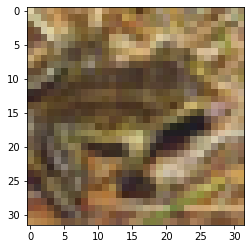

In [155]:
plt.imshow(trainset.data[228])

In [156]:
trainset, valset = random_split(trainset, [45000, 5000])
len(trainset), len(valset)

(45000, 5000)

In [157]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [222]:
class ResidualBlock(nn.Module):
    
    def __init__(self, input_ch, output_ch, identity_downsample=None, stride=1, dropout_p=0.1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(input_ch, output_ch, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(output_ch)
        self.conv2 = nn.Conv2d(output_ch, output_ch, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(output_ch)
        self.do = nn.Dropout(dropout_p)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample
        
    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        x += identity
        x = self.relu(x)
        x = self.do(x)
        return x

In [223]:
class ResNet18(nn.Module):
    
    def __init__(self, image_channels, num_classes):
        
        super(ResNet18, self).__init__()
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        #resnet layers
        self.layer1 = self.__make_layer(64, 64, stride=1)
        self.layer2 = self.__make_layer(64, 128, stride=2)
        self.layer3 = self.__make_layer(128, 256, stride=2)
        self.layer4 = self.__make_layer(256, 512, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
        
    def __make_layer(self, in_channels, out_channels, stride):
        
        identity_downsample = None
        if stride != 1:
            identity_downsample = self.identity_downsample(in_channels, out_channels)
            
        return nn.Sequential(
            ResidualBlock(in_channels, out_channels, identity_downsample=identity_downsample, stride=stride), 
            ResidualBlock(out_channels, out_channels)
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        
        x = self.avgpool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc(x)
        return x 
    
    def identity_downsample(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(out_channels)
        )

In [224]:
model = ResNet18(3, 10)

In [225]:
#count trainable parameters of the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(model)

12555018

In [226]:
#move the model to the device
model.to(device)
next(model.parameters()).is_cuda

True

In [227]:
#define everything we need for training
epochs = 25
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

In [228]:
def draw_curve(current_epoch):
    #if device == f'cuda:{device_id}':
    #    y_err = y_err.cpu()
    x_epoch.append(current_epoch)
    ax0.plot(x_epoch, y_loss['train'], 'bo-', label='train')
    ax0.plot(x_epoch, y_loss['val'], 'ro-', label='val')
    ax1.plot(x_epoch, y_err['train'], 'bo-', label='train')
    ax1.plot(x_epoch, y_err['val'], 'ro-', label='val')
    if current_epoch == 0:
        ax0.legend()
        ax1.legend()
    fig.savefig('train.jpg')

In [229]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=50):
    
    since = time.time()
    val_acc_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']: # Each epoch has a training and validation phase
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]: # Iterate over data
                
                #inputs = transforms.functional.resize(inputs, (112, 112))
                inputs = inputs.to(device)

                labels = labels.to(device)

                optimizer.zero_grad() # Zero the parameter gradients

                with torch.set_grad_enabled(phase == 'train'): # Forward. Track history if only in train
                    
                    outputs = model(inputs)
                    #outputs.to('cpu')
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train': # Backward + optimize only if in training phase
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            
            if phase == 'val': # Adjust learning rate based on val loss
                lr_scheduler.step(epoch_loss)
                
            epoch_acc = (running_corrects.double() / len(dataloaders[phase].dataset)).cpu()
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            y_loss[phase].append(epoch_loss)
            y_err[phase].append(1.0 - epoch_acc)


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

            if phase == 'val':
                draw_curve(epoch)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

Epoch 1/25
----------
train Loss: 1.4235 Acc: 0.4848
val Loss: 1.2009 Acc: 0.5744

Epoch 2/25
----------
train Loss: 1.0244 Acc: 0.6337
val Loss: 1.1514 Acc: 0.6164

Epoch 3/25
----------
train Loss: 0.8331 Acc: 0.7057
val Loss: 0.9071 Acc: 0.6910

Epoch 4/25
----------
train Loss: 0.7013 Acc: 0.7510
val Loss: 0.7870 Acc: 0.7288

Epoch 5/25
----------
train Loss: 0.6021 Acc: 0.7879
val Loss: 0.6431 Acc: 0.7720

Epoch 6/25
----------
train Loss: 0.5292 Acc: 0.8137
val Loss: 0.7009 Acc: 0.7698

Epoch 7/25
----------
train Loss: 0.4572 Acc: 0.8392
val Loss: 0.6993 Acc: 0.7714

Epoch 8/25
----------
train Loss: 0.3933 Acc: 0.8614
val Loss: 0.6621 Acc: 0.7828

Epoch 9/25
----------
train Loss: 0.3422 Acc: 0.8781
val Loss: 0.6876 Acc: 0.7842

Epoch 10/25
----------
train Loss: 0.2963 Acc: 0.8940
val Loss: 0.6551 Acc: 0.7972

Epoch 11/25
----------
train Loss: 0.2491 Acc: 0.9118
Epoch 00011: reducing learning rate of group 0 to 1.0000e-05.
val Loss: 0.6683 Acc: 0.7960

Epoch 12/25
----------


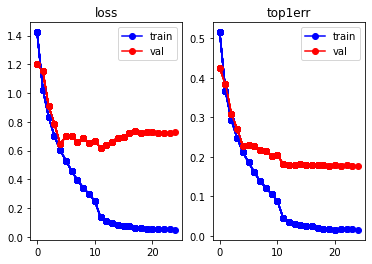

In [230]:
fig = plt.figure()
ax0 = fig.add_subplot(121, title="loss")
ax1 = fig.add_subplot(122, title="top1err")
x_epoch = []
y_loss = {}  # loss history
y_loss['train'] = []
y_loss['val'] = []
y_err = {}
y_err['train'] = []
y_err['val'] = []

model, _ = train_model(model, {"train": trainloader, "val": valloader}, criterion, optimizer, epochs)

In [232]:
correct = 0
total = 0

model.eval()
labels = []
for inputs, labels_ in testloader:
    inputs = transforms.functional.resize(inputs, (32, 32))
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    predictions = predictions.to("cpu")
    total += labels_.size(0)
    correct += torch.sum(predictions == labels_.data)

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 81 %


C:\Users\ciril\AppData\Local\Temp/ipykernel_5152/2010180996.py:15: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')
